# Análise da Rentabilidade de Fundos

### Inicializações

In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import yfinance as yf

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2024-05-18    0.91917
2024-05-17    0.91915
2024-05-16    0.92013
2024-05-15    0.91828
2024-05-14    0.92446
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [3]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date']).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).bfill().ffill()

#df_cotacoes

### Obter informação de transações

In [4]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates.iloc[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']].iloc[0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)
df_historico['Cotacao de resgate'] = df_historico['Cotacao de resgate'].astype(float)

### Cálculo Rentabilidade do Histórico

In [5]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)
df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100

df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']


print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.7465331664162136
Ganho Absoluto 34307.16825744977 em 1964300.988789316
Rentabilidade Média Anual 6.338940822935468


### Cálculo Rentabilidade do Portfólio

In [6]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 0.5522293967014065
Ganho Absoluto 1905.0060016387456 em 344966.4239205424 = 346871.42992218124
Rentabilidade Média Anual 7.041798668374644


### Rentabilidade Global

In [7]:

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() 
dias_medio += (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum()
dias_medio_div = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum() + (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
dias_medio = dias_medio / dias_medio_div
ganho = df_portofolio['Ganho Absoluto'].sum() + df_historico['Ganho Absoluto'].sum()
ganho_relativo = ganho / (sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']) + sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))
print("Rentabilidade Média Anual", 100*(math.pow(ganho_relativo+1, float(365.0/dias_medio))-1))


Rentabilidade Média Anual 6.376323964670627


In [8]:
df_portofolio[["Code","Nome",'Quantidade','Valor Actual','Ganho Absoluto']].groupby(by=["Code","Nome"]).sum().sort_values(by='Nome', ascending=True)

,,Quantidade,Valor Actual,Ganho Absoluto
Code,Nome,,,
LU1124235240,Aberdeen Diversified Income,903.76000,8639.945600,100.949992
LU1890834598,Allianz Global Water,81.00500,14947.852650,-119.077350
LU0823433858,BNP Paribas Funds Turkey,38.04900,10888.482330,540.124320
IE00B432GG85,BNY Mell Glb Dyn Bond A,3609.77000,4873.189500,-62.809998
LU1508158513,BlackRock Asia Pacific,171.55000,24001.560500,515.557100
LU2210151697,FF Abs Ret Gb Eq,3301.37000,38658.946960,318.461785
LU2207571022,FF Absolute Return Global Hedged,1886.04000,19011.283200,-37.720800
LU0594300096,Fidelity China Consumer,735.19000,13755.404900,323.483600
LU0788144201,Fidelity China RMB Bond,242.77000,3202.136300,-55.594330


<Axes: title={'center': ' 4.00%'}, xlabel='Date'>

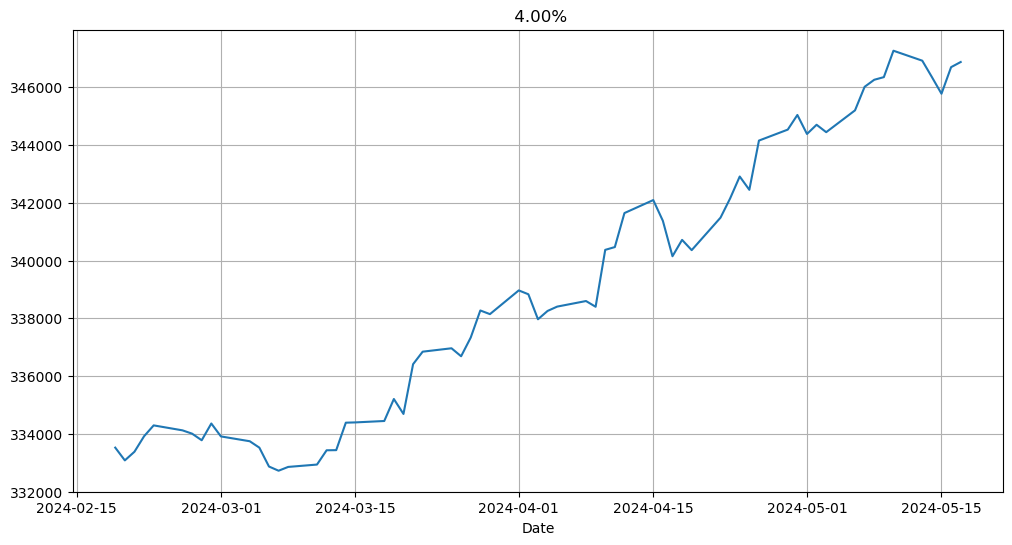

In [9]:
#Get the Portofolio
size=65
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
#print(df_meta.sort_index())
#print(set(df_cotacoes.columns))
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(12,6),grid=True,title = f"{df_global.iloc[0]/df_global.iloc[-1]-1: .2%}")

# SP 500 and MSCI Global Comparision

In [10]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500.index = ds_sp500.index.date
ds_sp500.name = "SP500"
tickers = ['MSCI']
start_date = '2021-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ds_msci = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
ds_msci.name = 'MSCI'
ds_msci = ds_msci.reindex(pd.date_range(ds_msci.index.min(),ds_msci.index.max())).interpolate()
ds_msci.index = ds_msci.index.date
ds_msci

[*********************100%%**********************]  1 of 1 completed


2021-01-04    423.361084
2021-01-05    417.295685
2021-01-06    420.971741
2021-01-07    429.165375
2021-01-08    437.910400
                 ...    
2024-05-13    483.984680
2024-05-14    486.516357
2024-05-15    488.459991
2024-05-16    497.510010
2024-05-17    505.329987
Name: MSCI, Length: 1230, dtype: float64

In [11]:
df_sp500_hist = df_historico[['Dias']].copy()
df_sp500_hist['Cost'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
#df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[np.datetime64(x['Data de subscricao'])],axis=1)
df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[x['Data de subscricao']],axis=1)

df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_historico.apply(lambda x: (ds_sp500[x['Data de resgate']]-ds_sp500[x['Data de subscricao']]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


SP500 Histórico: Custo=1964300.9887893135, Ganho=88392.04006545937
Rentabilidade SP500 Histórico 16.911113926655162


In [12]:
df_quotes = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True).sort_index(ascending=True).ffill().dropna(axis=1)
df_quotes.index = [x.date() for x in df_quotes.index]

#Rentabilidade das transacçoes realizadas

def p_value_on_date(df_t, d):
    # amount in the end of the day
    df = df_t[(df_t['Data de subscricao']<=d) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>d))]
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] * (exchange_rates.loc[d] if x['Moeda'] == 'USD' else 1), axis=1).sum()

def b_value_on_date(df_t, d):
    # amount bought on d
    df = df_t[df_t['Data de subscricao']==d]
    if len(df)==0:
        return 0
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] * (exchange_rates.loc[d] if x['Moeda'] == 'USD' else 1), axis=1).sum()

def s_value_on_date(df_t, d):
    # amount sold on d
    df = df_t[df_t['Data de resgate']==d]
    if len(df)==0:
        return 0
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] * (exchange_rates.loc[d] if x['Moeda'] == 'USD' else 1), axis=1).sum()

def profitablity_graph(first_date, figsize=(12,6)):

    # Transactions
    df_t = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)].copy()
    df_t = df_t[(pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=first_date)]

    # df_t contain a copye of the transactions for which quotes exists (df_quotes)
    first_date = max(first_date,df_t['Data de subscricao'].min())
    last_date = min(df_quotes.index.max(),exchange_rates.index.max())
    
    # Portofolio dataframe
    p_data = pd.DataFrame(data={'date':df_quotes[first_date:last_date].index}) # Init with date ranges
    p_data.index = [x for x in p_data['date']]
    p_data['p_value'] = p_data.apply(lambda x: p_value_on_date(df_t,x['date']),axis=1)
    p_data['b_value'] = p_data.apply(lambda x: b_value_on_date(df_t,x['date']),axis=1)
    p_data['s_value'] = p_data.apply(lambda x: s_value_on_date(df_t,x['date']),axis=1)
    p_data['pnd_value'] = p_data['p_value'] - p_data['b_value'] + p_data['s_value']
    p_data['daily_growth'] = (p_data['pnd_value'].shift(-1)/p_data['p_value']).shift(1,fill_value=1)
    p_data['Portofolio'] = p_data['daily_growth'].cumprod()

    profit_period = p_data['Portofolio'].iloc[-1]-1
    profit_year = p_data['Portofolio'].iloc[-1]**(365/(last_date - first_date).days)-1
    title = f"Profitability: { profit_period: .2%} / period; {profit_year:.2%} / year"
    sp500_data = (ds_sp500[first_date:].ffill().pct_change().fillna(0)+1).cumprod()
    #msci_data = (ds_msci[first_date:].ffill().pct_change().fillna(0)+1).cumprod()
    #pd.concat([sp500_data, msci_data, p_data['Portofolio']],axis=1).plot(title=title,figsize=figsize,grid=True)
    pd.concat([sp500_data, p_data['Portofolio']],axis=1).plot(title=title,figsize=figsize,grid=True)


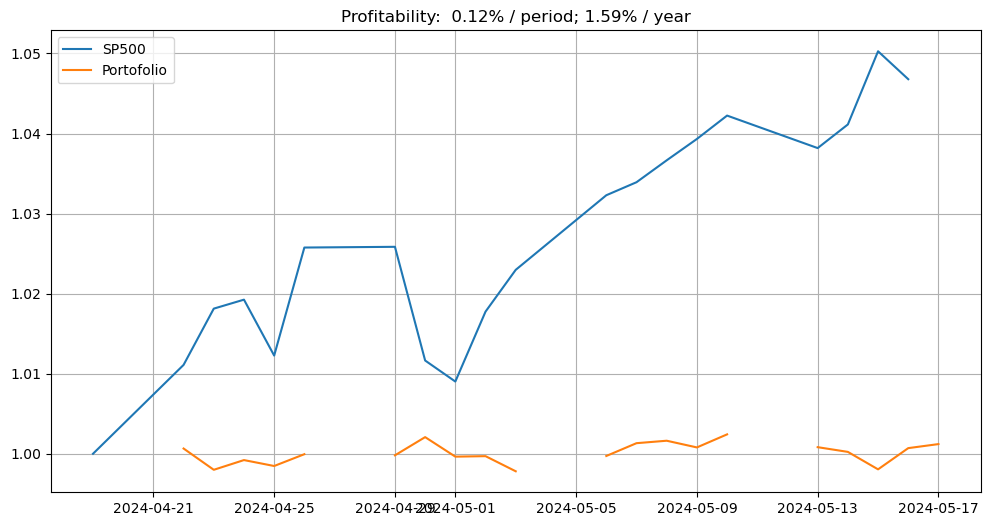

In [13]:
profitablity_graph(date.today()-timedelta(days=30))

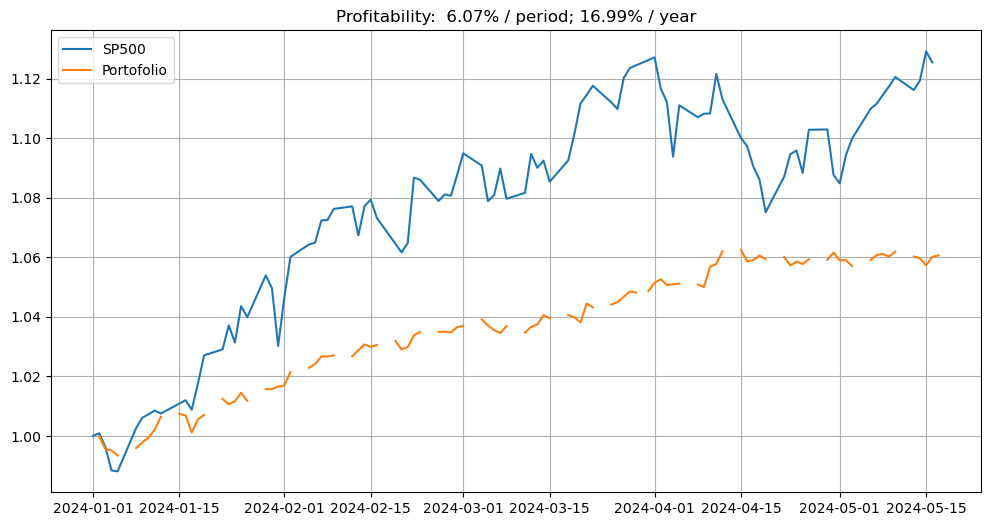

In [14]:
profitablity_graph(date(2024,1,1))

2024-05-17


<Axes: >

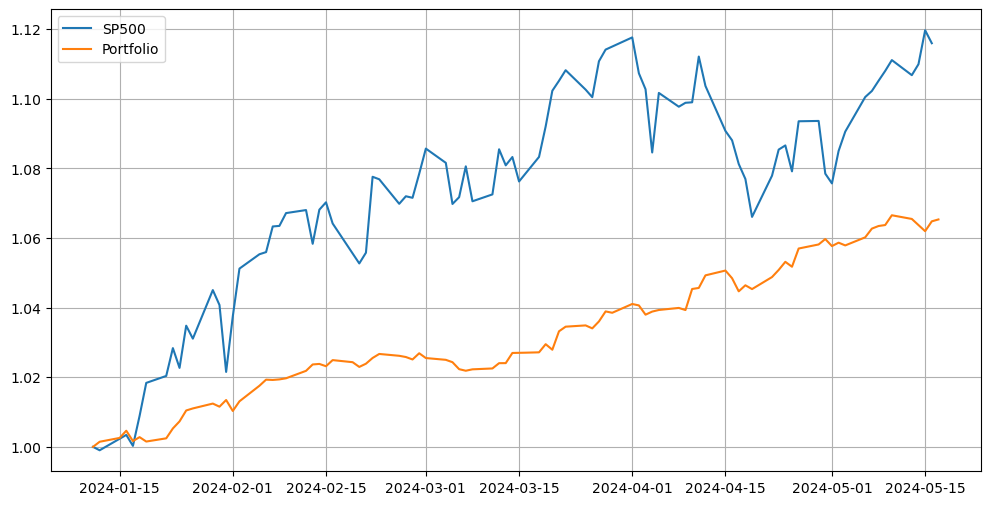

In [15]:
#Comparision of the current portfolio
n_days = 92
ds = df_cotacoes[:n_days].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1).sort_index()
#ds.index = [pd.Timestamp(x) for x in ds.index]
ds = ds.reindex(pd.date_range(ds.index.min(),ds.index.max())).interpolate()
ds.index = ds.index.date
ds.name = "Portfolio"
print(ds.index[-1])
pd.concat([(ds_sp500[ds.index.min():].ffill().pct_change().fillna(0)+1).cumprod(), (ds.ffill().pct_change().fillna(0)+1).cumprod()],axis=1).plot(figsize=(12,6),grid=True)